# **CeKulit**

skin Classification using CNN

In [7]:
!pip install gdown -q

## Import Labriray

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks, Input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.applications import ResNet50
from keras.applications import ResNet50V2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from copy import deepcopy
from google.colab import files
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import pandas as pd
from pathlib import Path
import tensorflow as tf
import zipfile
import shutil
import os
import tempfile
import cv2
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import splitfolders
import gdown


## Download Dataset

In [11]:
url = "https://drive.google.com/file/d/1m2We51xSr3-wg3Wm6CLb20C2SkxGKHjD/view?usp=sharing"
gdown.download(url, quiet=True, fuzzy=True)

'skindataset.zip'

In [12]:
!unzip skindataset.zip -d skin_dataset

Archive:  skindataset.zip
  inflating: skin_dataset/Oily-Dry-Skin-Types/README.dataset.txt  
  inflating: skin_dataset/Oily-Dry-Skin-Types/test/dry/dry_10583924a54a7cbcf5d0_jpg.rf.7c4cb0ac9522f3a0faaf230527e1abe9.jpg  
  inflating: skin_dataset/Oily-Dry-Skin-Types/test/dry/dry_1d3b1b41c06745c89fb6_jpg.rf.9fe7b2181a36c2b6f67744be1af2fdd7.jpg  
  inflating: skin_dataset/Oily-Dry-Skin-Types/test/dry/dry_2e2591d4cf31b8e024a6_jpg.rf.e8a8db4db95cd0a0df0275d75fcd87a0.jpg  
  inflating: skin_dataset/Oily-Dry-Skin-Types/test/dry/dry_304ff9ea442145481f67_jpg.rf.26e1ca5ca2eb32f5c89509c670ca967a.jpg  
  inflating: skin_dataset/Oily-Dry-Skin-Types/test/dry/dry_33489ccedfbd77039b4d_jpg.rf.bff22d94ad08b5402f1feb8e304a7368.jpg  
  inflating: skin_dataset/Oily-Dry-Skin-Types/test/dry/dry_3cff4d4b05b7b88def12_jpg.rf.61f7ed0c6569bde348734178e19a55f7.jpg  
  inflating: skin_dataset/Oily-Dry-Skin-Types/test/dry/dry_4b06e68067862ee761ab_jpg.rf.52e7f8c3af0d6b1dd3e3f224b735fc18.jpg  
  inflating: skin_dataset

In [13]:
base_dir = 'skin_dataset/Oily-Dry-Skin-Types'
categories = [['dry', 'normal', 'oily']]

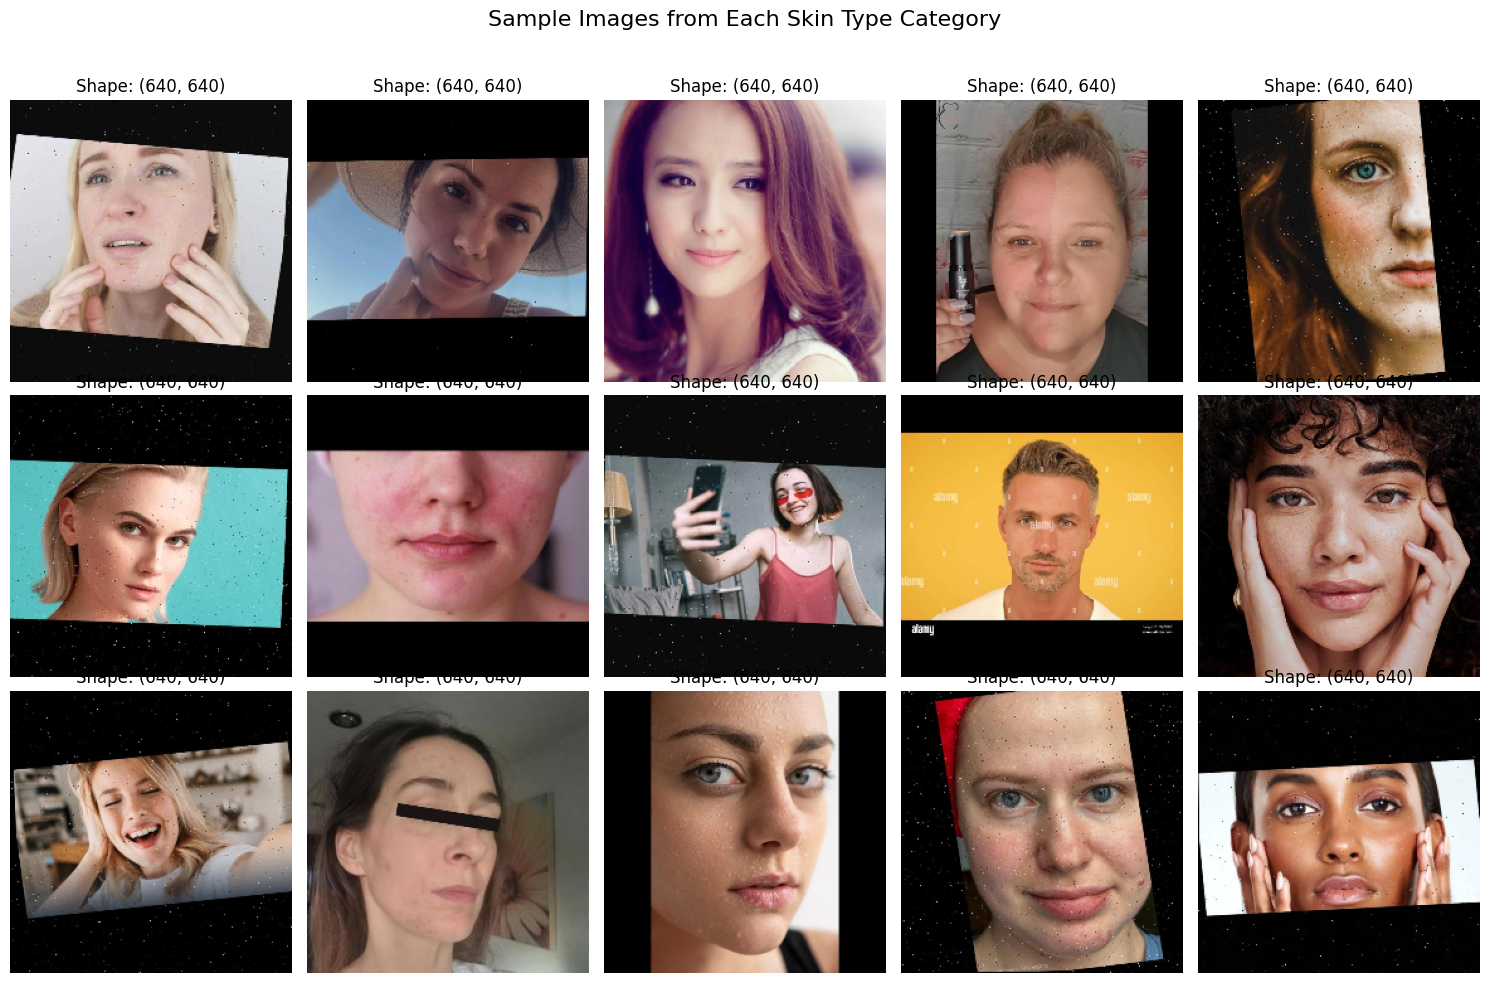

In [14]:
# Function to display images from the dataset
def display_images_with_shape(base_dir, categories, img_size=(224, 224), num_images=5):
    fig, axes = plt.subplots(len(categories), num_images, figsize=(15, 10))
    fig.suptitle("Sample Images from Each Skin Type Category", fontsize=16)

    for i, category in enumerate(categories):
        folder_path = os.path.join(base_dir, category)
        image_files = os.listdir(folder_path)[:num_images]

        for j, img_file in enumerate(image_files):
            img_path = os.path.join(folder_path, img_file)
            img = cv2.imread(img_path)

            if img is None:
                print(f"Warning: Could not load image {img_path}")
                continue

            img_resized = cv2.resize(img, img_size)

            axes[i, j].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
            axes[i, j].axis('off')
            axes[i, j].set_title(f"Shape: {img.shape[:2]}")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Example Usage
train_dir = '/content/skin_dataset/Oily-Dry-Skin-Types/train'
categories = ['dry', 'normal', 'oily']

display_images_with_shape(train_dir, categories)


## Analyst Data

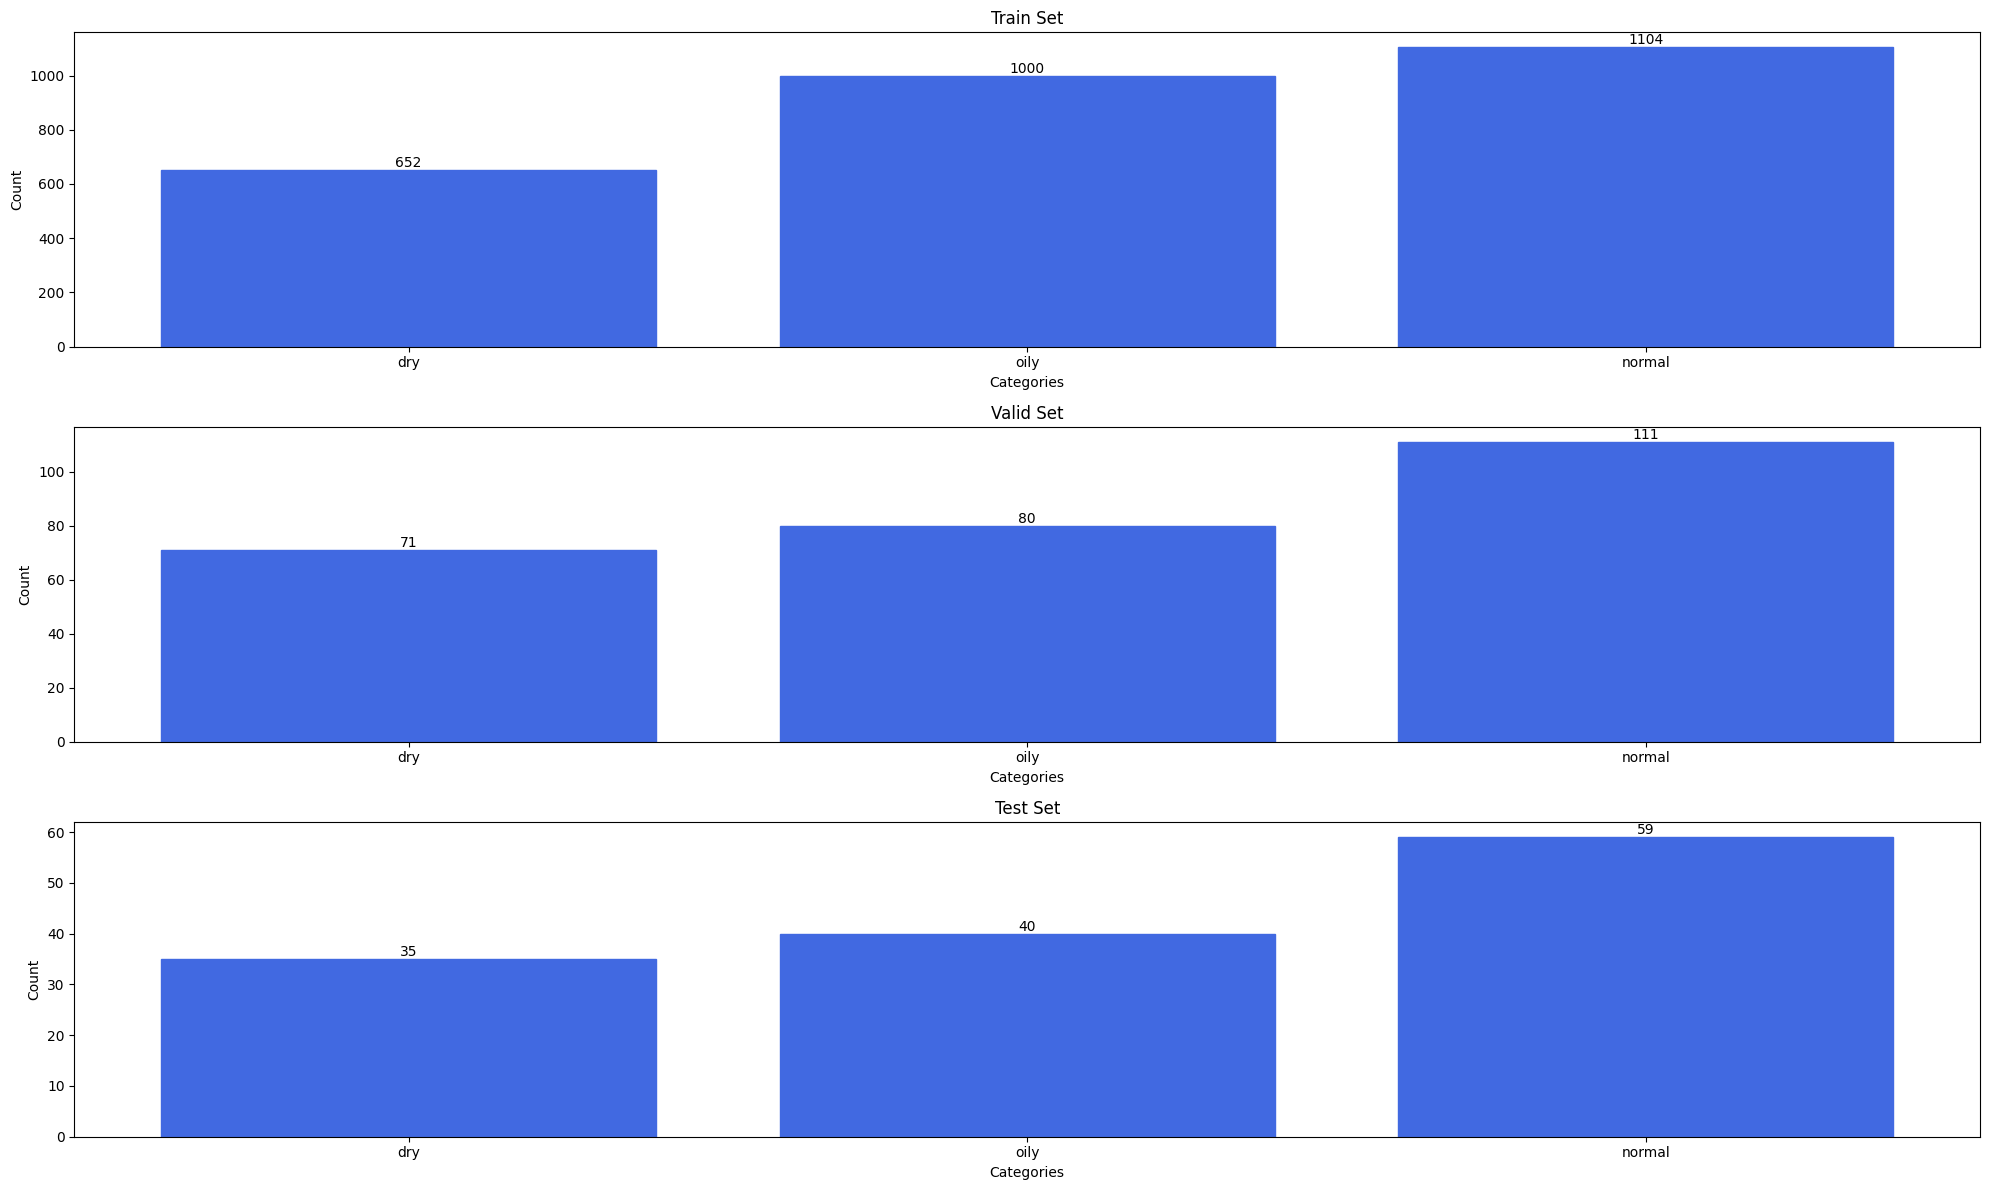

In [18]:
categories = os.listdir(train_dir)

not_splitted = ['dry', 'normal', 'oily']

dataset_folder = '/content/skin_dataset/Oily-Dry-Skin-Types'

data_splits = ['train', 'valid', 'test']

counts = {split: {category: 0 for category in categories} for split in data_splits}

for split in data_splits:
    for category in categories:
        category_folder = os.path.join(dataset_folder, split, category)
        counts[split][category] = len(os.listdir(category_folder))

fig, axes = plt.subplots(3, 1, figsize=(20, 12))

for i, split in enumerate(data_splits):
    ax = axes[i]
    categories_counts = [counts[split][category] for category in categories]
    bars = ax.bar(categories, categories_counts)
    ax.set_title(f'{split.capitalize()} Set')
    ax.set_xlabel('Categories')
    ax.set_ylabel('Count')

    for i in not_splitted:
      i = i.lower().replace(" ", "_")
      bars[categories.index(i)].set_color('royalblue')

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f'{height}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Data Augmentation

In [20]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

training_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale = 1./255)
train_generator = training_datagen.flow_from_directory(
	train_dir,
 	target_size=(224,224),
	class_mode='categorical',
  batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
	validation_dir,
  target_size=(224,224),
	class_mode='categorical',
  batch_size=32
)

test_generator = validation_datagen.flow_from_directory(
	test_dir,
  target_size=(224,224),
	class_mode='categorical',
  batch_size=32
)

Found 2756 images belonging to 3 classes.
Found 262 images belonging to 3 classes.
Found 134 images belonging to 3 classes.


## Training the Model

In [21]:
# Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 256)         │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 128)         │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,347,331 (8.95 MB)

 Trainable params: 2,347,331 (8.95 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', patience=8, restore_best_weights=True, verbose=1
)

In [24]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 57s 503ms/step - accuracy: 0.3992 - loss: 1.0969 - val_accuracy: 0.4237 - val_loss: 1.0889
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 65s 414ms/step - accuracy: 0.4138 - loss: 1.0702 - val_accuracy: 0.4237 - val_loss: 1.0864
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 411ms/step - accuracy: 0.4029 - loss: 1.0757 - val_accuracy: 0.4237 - val_loss: 1.0851
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 418ms/step - accuracy: 0.3902 - loss: 1.0772 - val_accuracy: 0.4237 - val_loss: 1.0849
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 421ms/step - accuracy: 0.4059 - loss: 1.0729 - val_accuracy: 0.4198 - val_loss: 1.0878
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 44s 452ms/step - accuracy: 0.3804 - loss: 1.0771 - val_accuracy: 0.4237 - val_loss: 1.0849
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 79s 419ms/step - accuracy: 0.4173 - loss: 1.0723 - val_accuracy: 0.4237 - val_loss: 1.0879
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 415ms/step - accuracy: 0.3903 - loss: 1.0768 - val_accuracy: 0.423

## Model Evaluation

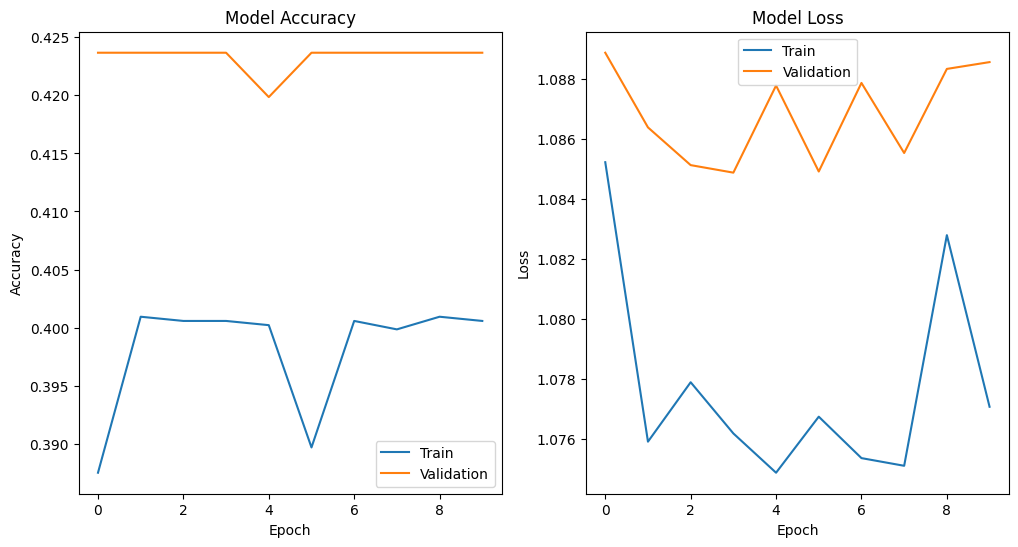

In [25]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

## Transfer Learning

In [26]:
label_index = {"dry": 0, "normal": 1, "oily": 2}
index_label = {0: "dry", 1: "normal", 2: "oily"}

In [27]:
def create_df(base):
    dd = {"images": [], "labels": []}
    for i in os.listdir(base):
        label = os.path.join(base, i)
        for j in os.listdir(label):
            img = os.path.join(label, j)
            dd["images"] += [img]
            dd["labels"] += [label_index[i]]
    return pd.DataFrame(dd)

In [28]:
train_df = create_df("/content/skin_dataset/Oily-Dry-Skin-Types/train")
val_df = create_df("/content/skin_dataset/Oily-Dry-Skin-Types/valid")
test_df = create_df("/content/skin_dataset/Oily-Dry-Skin-Types/test")

In [29]:
train_df = pd.concat([train_df, val_df, test_df])

In [30]:
#Defining training parameters
EPOCHS = 20
LR = 0.1
STEP = 15
GAMMA = 0.1
BATCH = 32
OUT_CLASSES = 3
IMG_SIZE = 224

In [31]:
class CloudDS(Dataset):
    def __init__(self, data, transform):
        super(CloudDS, self).__init__()
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, x):
        img, label = self.data.iloc[x, 0], self.data.iloc[x, 1]
        img = Image.open(img).convert("RGB")
        img = self.transform(np.array(img))

        return img, label

In [32]:
train_transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                transforms.RandomVerticalFlip(0.6),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])])

transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])])

In [33]:
train, testing = train_test_split(train_df, random_state=42, test_size=0.2)
val, test = train_test_split(testing, random_state=42, test_size=0.5)

In [34]:
train_ds = CloudDS(train, train_transform)
val_ds = CloudDS(val, transform)

In [35]:
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

In [36]:
#download resnet
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet.fc.in_features
resnet.fc.in_features = nn.Linear(num_ftrs, OUT_CLASSES)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 127MB/s]


In [37]:
resnet.trainable = False

In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [39]:
#Training
model = deepcopy(resnet)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [40]:
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for i in range(1, EPOCHS+1):
    model.train()

    diff = 0
    total = 0
    acc = 0

    for data, target in train_dl:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        out = model(data)
        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)
        loss.backward()
        optimizer.step()

    train_loss += [diff/total]
    train_acc += [acc/total]

    model.eval()

    diff = 0
    total = 0
    acc = 0

    with torch.no_grad():
        for data, target in val_dl:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)

    val_loss += [diff/total]
    val_acc += [acc/total]

    if val_acc[-1] > best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)

    scheduler.step()

    print("Epochs {} train_loss : {} acc : {} val_loss : {} acc : {}".format(i, train_loss[-1],
                                                                    train_acc[-1], val_loss[-1],
                                                                    val_acc[-1]))

Epochs 1 train_loss : 0.0459611019838523 acc : 0.4601348671162237 val_loss : 0.02991094948753478 acc : 0.5873015873015873
Epochs 2 train_loss : 0.023379831832347053 acc : 0.6834589448631495 val_loss : 0.034194442204066686 acc : 0.49523809523809526
Epochs 3 train_loss : 0.01527584014029694 acc : 0.813962713209044 val_loss : 0.02588187825112116 acc : 0.692063492063492
Epochs 4 train_loss : 0.01174559265386959 acc : 0.8603728679095597 val_loss : 0.02915122149482606 acc : 0.6730158730158731
Epochs 5 train_loss : 0.007395978325454075 acc : 0.9166997223324078 val_loss : 0.02621716156838432 acc : 0.7206349206349206
Epochs 6 train_loss : 0.005342610740427553 acc : 0.9397064656882189 val_loss : 0.028113288728017657 acc : 0.692063492063492
Epochs 7 train_loss : 0.0034681810550051804 acc : 0.9654898849662832 val_loss : 0.020740542099589393 acc : 0.8158730158730159
Epochs 8 train_loss : 0.0027241797771235393 acc : 0.9682665608885362 val_loss : 0.026696683490087116 acc : 0.7301587301587301
Epochs 9

## Model Evaluation (TF)

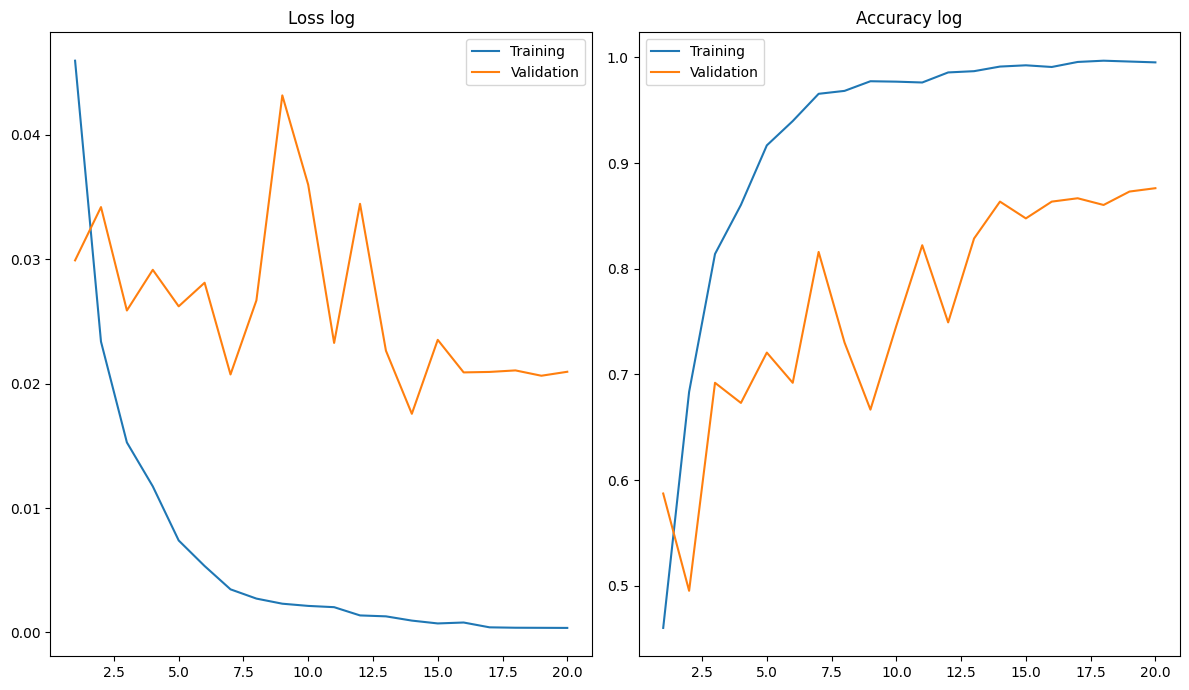

In [41]:
epochs = list(range(1, EPOCHS+1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
axes[0].plot(epochs, train_loss)
axes[0].plot(epochs, val_loss)
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Loss log")

axes[1].plot(epochs, train_acc)
axes[1].plot(epochs, val_acc)
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Accuracy log")

plt.tight_layout()
plt.show()

## Testing The Model

In [42]:
def predict(x):
    img = Image.open(x).convert("RGB")
    img = transform(np.array(img))
    img = img.view(1, 3, 224, 224)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()

        out = best_model(img)

        return out.argmax(1).item()

In [43]:
pred = []
truth = []

for i in range(test.shape[0]):
    pred += [predict(test.iloc[i, 0])]
    truth += [test.iloc[i, 1]]

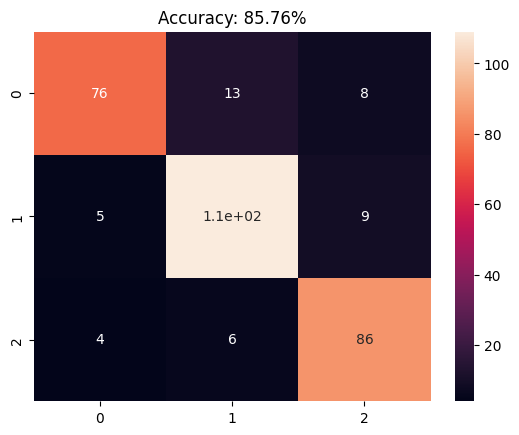

In [44]:
score = accuracy_score(truth, pred)
report = classification_report(truth, pred)
cm = confusion_matrix(truth, pred)
sns.heatmap(cm, annot=True)
plt.title("Accuracy: {}%".format(round(score*100, 2)))
plt.show()

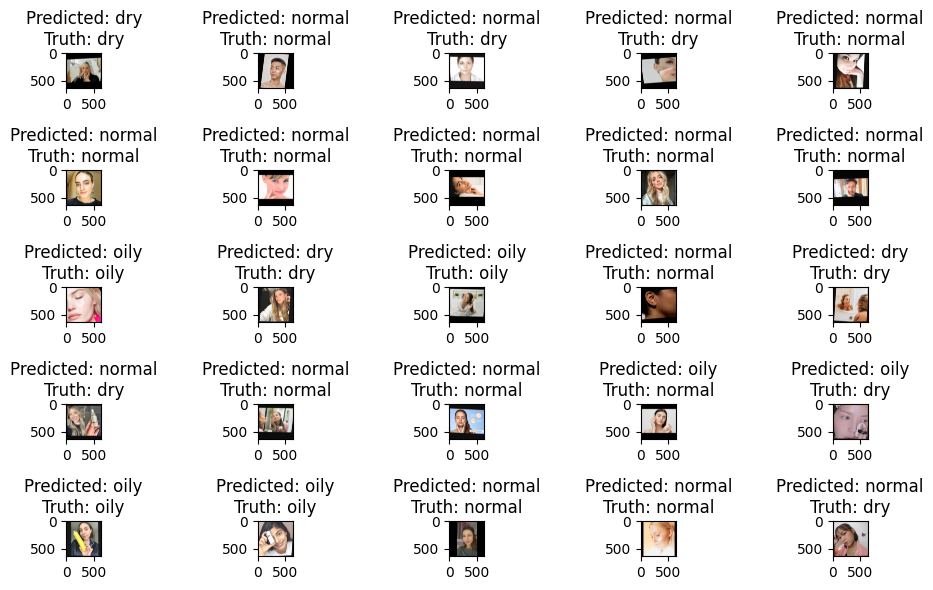

In [45]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 6))
index = 0
for i in range(5):
    for j in range(5):
        img = test.iloc[index, 0]
        img = Image.open(img).convert("RGB")
        axes[i][j].imshow(img)
        axes[i][j].set_title("Predicted: {}\nTruth: {}".format(index_label[pred[index]], index_label[truth[index]]))
        index += 1

plt.tight_layout()
plt.show()

## Save Model

In [46]:
# Save the best model
def save_model(model, filename='best_skin_classification_model.pth'):
    """
    Save the trained model to a specified filename

    Args:
        model (torch.nn.Module): Trained PyTorch model
        filename (str): Filename to save the model
    """
    torch.save({
        'model_state_dict': model.state_dict(),
        'label_index': label_index,  # Save label mapping for later use
        'model_architecture': type(model).__name__
    }, filename)

# Download the saved model
def load_model(filename='best_skin_classification_model.pth', device='cuda'):
    """
    Load a previously saved PyTorch model

    Args:
        filename (str): Filename of the saved model
        device (str): Device to load the model on (cuda/cpu)

    Returns:
        Loaded model with saved state dictionary
    """
    checkpoint = torch.load(filename, map_location=torch.device(device))

    # Recreate the model architecture
    model = resnet50()
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, OUT_CLASSES)

    # Load the state dictionary
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()  # Set to evaluation mode

    return model

# Save the best model
save_model(best_model)

# Optional: If you want to download in Google Colab
from google.colab import files
files.download('best_skin_classification_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>